# Import Libraries

In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torch.optim as optim
from torchvision import datasets, transforms

In [ ]:
# HYPERPARAMS
num_epochs = 20
batch_size = 128
lr = 0.01

# CONSTANTS
NUM_CLASSES = 10
DATA_MEAN = (0.1307,)
DATA_STD = (0.3081,)

# cuda availability
cuda_available = torch.cuda.is_available()
device = "cuda" if cuda_available else "cpu"

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [ ]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                    #    transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                    #    transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.RandomAffine(degrees=7,translate=(0.15,0.15), scale=(0.7, 1.3), shear=8, fill=(0,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize(DATA_MEAN, DATA_STD) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize(DATA_MEAN, DATA_STD)
                                       ])


# Dataset and Creating Train/Test Split

In [ ]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [ ]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=batch_size, num_workers=2, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def display_image(image, title: str="Class label"):
    """
    This function essentially takes in normalized tensors and the
    Un-normalize them and display the image as output.

    Args:
    ----
    image: Image which we want to plot.
    title: Label for that image.
    """
    image = image.numpy().transpose((1, 2, 0)) # (C, H, W) --> (H, W, C)
    # Convert mean and std to numpy array
    mean = np.asarray(DATA_MEAN)
    std = np.asarray(DATA_STD)
    # unnormalize the image
    image = std * image + mean
    image = np.clip(image, 0, 1)
    
    print(title)
    fig = plt.figure() # Create a new figure
    fig.set_figheight(15)
    fig.set_figwidth(15)
    ax = fig.add_subplot(111)
    ax.axis("off") # Sqitch off the axis
    ax.imshow(image)

['6', '1', '4', '0', '7', '1', '8', '9', '0', '1', '2', '4', '2', '5', '9', '3', '9', '5', '1', '4', '1', '1', '3', '3', '2', '4', '3', '7', '8', '8', '1', '1', '4', '5', '4', '5', '0', '1', '0', '0', '7', '3', '7', '5', '0', '4', '1', '5', '3', '7', '9', '4', '6', '2', '6', '8', '5', '1', '5', '0', '0', '0', '3', '9', '9', '2', '4', '9', '2', '0', '3', '6', '5', '1', '9', '8', '9', '3', '1', '6', '6', '1', '0', '3', '8', '0', '9', '8', '5', '3', '3', '0', '8', '4', '1', '9', '7', '0', '2', '4', '8', '4', '7', '8', '5', '6', '1', '8', '5', '8', '3', '5', '0', '3', '0', '4', '7', '4', '3', '8', '4', '7', '1', '5', '0', '5', '5', '7']


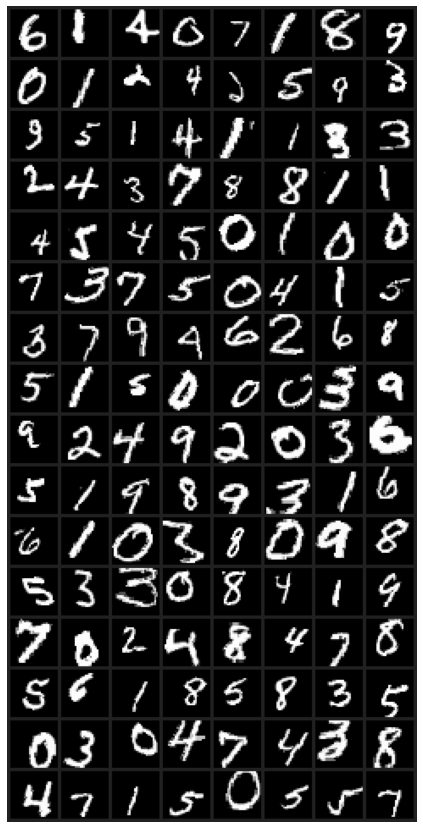

In [ ]:
# Iteratre over and get 1 batch of training data
data, targets = next(iter(train_loader))

# make_grid takes all tensors(batch) and joins them into a single big tensor image (almost)
batch_grid = torchvision.utils.make_grid(data) 

display_image(batch_grid, title=[str(cls.item()) for cls in targets])

# The model
Let's start with the model we first saw

In [ ]:
# ------99.2 /8.8k
import torch.nn.functional as F
dropout_value = 0.0
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=12, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(12),
            nn.Conv2d(in_channels=12, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Conv2d(in_channels=16, out_channels=6, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(6),
            nn.MaxPool2d(2, 2)
        ) # output_size = 12

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=6, out_channels=12, kernel_size=(3, 3), padding=0, bias=False), 
            nn.ReLU(),
            nn.BatchNorm2d(12),
            nn.Conv2d(in_channels=12, out_channels=14, kernel_size=(3, 3), padding=0, bias=False), 
            nn.ReLU(),
            nn.BatchNorm2d(14),
            nn.Conv2d(in_channels=14, out_channels=14, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(14),
            nn.Conv2d(in_channels=14, out_channels=14, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(14),
        ) 

        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
        ) # output_size = 1

        self.classifier = nn.Sequential(
            nn.Linear(14, 10))

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        # x = self.convblock3(x)
        x = self.gap(x)   
        x = x.view(-1, 14)
        x = self.classifier(x)

        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [ ]:
# !pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 12, 26, 26]             108
              ReLU-2           [-1, 12, 26, 26]               0
       BatchNorm2d-3           [-1, 12, 26, 26]              24
            Conv2d-4           [-1, 16, 24, 24]           1,728
              ReLU-5           [-1, 16, 24, 24]               0
       BatchNorm2d-6           [-1, 16, 24, 24]              32
            Conv2d-7            [-1, 6, 24, 24]              96
              ReLU-8            [-1, 6, 24, 24]               0
       BatchNorm2d-9            [-1, 6, 24, 24]              12
        MaxPool2d-10            [-1, 6, 12, 12]               0
           Conv2d-11           [-1, 12, 10, 10]             648
             ReLU-12           [-1, 12, 10, 10]               0
      BatchNorm2d-13           [-1, 12, 10, 10]              24
           Conv2d-14             [

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [ ]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

This time let's add a scheduler for out LR. 

In [ ]:
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.015, momentum=0.9)
scheduler = StepLR(optimizer, step_size=9, gamma=0.1)


EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 1


Loss=0.2920304238796234 Batch_id=468 Accuracy=83.17: 100%|██████████| 469/469 [00:15<00:00, 30.29it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0678, Accuracy: 9804/10000 (98.04%)

EPOCH: 2


Loss=0.1099965050816536 Batch_id=468 Accuracy=95.32: 100%|██████████| 469/469 [00:15<00:00, 29.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0540, Accuracy: 9841/10000 (98.41%)

EPOCH: 3


Loss=0.05505436658859253 Batch_id=468 Accuracy=96.20: 100%|██████████| 469/469 [00:16<00:00, 29.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0427, Accuracy: 9861/10000 (98.61%)

EPOCH: 4


Loss=0.0559239387512207 Batch_id=468 Accuracy=96.80: 100%|██████████| 469/469 [00:16<00:00, 27.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0340, Accuracy: 9896/10000 (98.96%)

EPOCH: 5


Loss=0.11785978823900223 Batch_id=468 Accuracy=97.18: 100%|██████████| 469/469 [00:16<00:00, 27.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0314, Accuracy: 9900/10000 (99.00%)

EPOCH: 6


Loss=0.1042698547244072 Batch_id=468 Accuracy=97.30: 100%|██████████| 469/469 [00:15<00:00, 29.49it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0303, Accuracy: 9902/10000 (99.02%)

EPOCH: 7


Loss=0.23318630456924438 Batch_id=468 Accuracy=97.31: 100%|██████████| 469/469 [00:15<00:00, 29.62it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0270, Accuracy: 9915/10000 (99.15%)

EPOCH: 8


Loss=0.1662347912788391 Batch_id=468 Accuracy=97.55: 100%|██████████| 469/469 [00:15<00:00, 29.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0270, Accuracy: 9916/10000 (99.16%)

EPOCH: 9


Loss=0.03322969749569893 Batch_id=468 Accuracy=97.44: 100%|██████████| 469/469 [00:15<00:00, 30.31it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0274, Accuracy: 9908/10000 (99.08%)

EPOCH: 10


Loss=0.11530936509370804 Batch_id=468 Accuracy=97.97: 100%|██████████| 469/469 [00:15<00:00, 29.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0205, Accuracy: 9938/10000 (99.38%)

EPOCH: 11


Loss=0.06971058994531631 Batch_id=468 Accuracy=98.10: 100%|██████████| 469/469 [00:15<00:00, 30.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0201, Accuracy: 9932/10000 (99.32%)

EPOCH: 12


Loss=0.05070294439792633 Batch_id=468 Accuracy=98.13: 100%|██████████| 469/469 [00:15<00:00, 30.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0196, Accuracy: 9938/10000 (99.38%)

EPOCH: 13


Loss=0.07360347360372543 Batch_id=468 Accuracy=98.24: 100%|██████████| 469/469 [00:15<00:00, 30.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0197, Accuracy: 9937/10000 (99.37%)

EPOCH: 14


Loss=0.02592841349542141 Batch_id=468 Accuracy=98.20: 100%|██████████| 469/469 [00:15<00:00, 30.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0193, Accuracy: 9940/10000 (99.40%)

EPOCH: 15


Loss=0.019798798486590385 Batch_id=468 Accuracy=98.23: 100%|██████████| 469/469 [00:15<00:00, 29.99it/s]



Test set: Average loss: 0.0190, Accuracy: 9944/10000 (99.44%)



Text(0.5, 1.0, 'Test Accuracy')

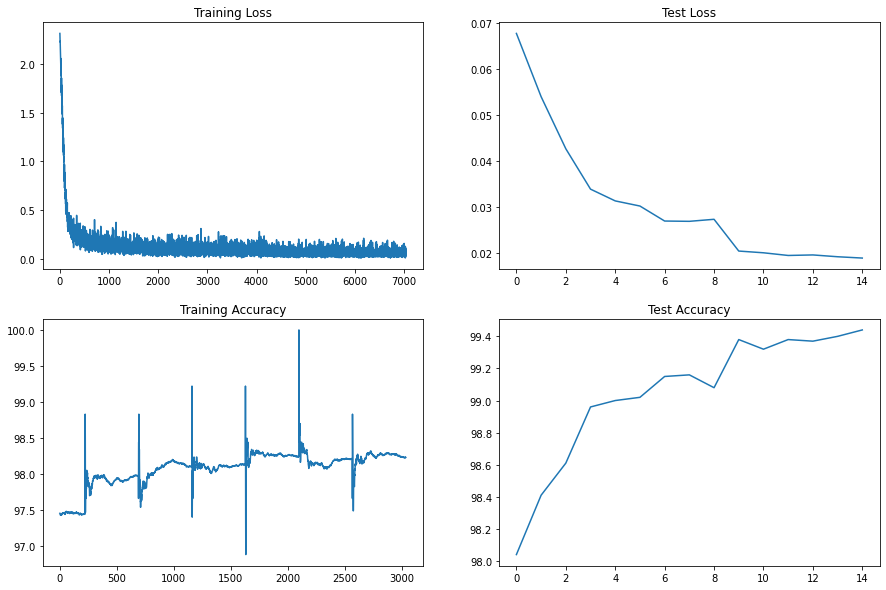

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")